In [42]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy.random as rd
plt.rcParams['figure.figsize'] = [18, 10]
plt.style.use('ggplot')
mpl.rcParams['axes.color_cycle'] = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854'] #from http://colorbrewer2.org

/Users/Asia/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


## Loading data


In [2]:
data = pd.read_stata('HCMST 2017 fresh sample for public sharing draft v1.1.dta')
data.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


### Chosen columns:
     pphhsize - Household Size
     relate_duration_at_w6_years - july 2017-year and month when rel started
     w6_friend_connect_4 - partner knows my friends and I know my partner's friends before metting
     w6_otherdate - In the past year, have you ever met someone for dating, for romance, or for sex
     S1 - Are you married? (output)

### Dropping rows, which had nulls and changing categorical data

In [3]:
data = data[['pphhsize', 'relate_duration_at_w6_years', 'w6_friend_connect_4', 'w6_otherdate', 'S1']].dropna()
data['pphhsize'] = data['pphhsize'].astype(float)
data = pd.get_dummies(data)

#### Rows with an answer *Refused* in *w6_otherdate* also admitted as null

In [4]:
data = data.loc[data['w6_otherdate_Refused'] == 0] 
data.drop('w6_otherdate_Refused', axis=1, inplace=True)

#### Renaming columns and splitting for train and test

In [5]:
data.rename(columns={'relate_duration_at_w6_years': 'relate_duration',
            'w6_friend_connect_4_Yes': 'friends_connect',
            'w6_otherdate_Yes, I have met at least one person for dating, romance, or sex besides [Partner Name] in  the past year.': 'otherdate',
            'S1_Yes, I am Married':'married'},
            inplace=True)
#fixed otherdate column, which was opposite value in previous notebooks
data = data.reset_index()
data = data[['pphhsize', 'relate_duration', 'friends_connect', 'otherdate', 'married']]

X_data, y_data = data[['pphhsize', 'relate_duration', 'friends_connect', 'otherdate']], data[['married']]
y_data = np.array(y_data).ravel()
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data)

### Training models

In [6]:
ran_clas = RandomForestClassifier(n_estimators=500)
ran_clas.fit(X_train, y_train)
y_pred = ran_clas.predict(X_test)

In [7]:
lin_clas = LogisticRegression()
lin_clas.fit(X_train, y_train)
y_predict_lin = lin_clas.predict(X_test)

In [8]:
dec_clas = DecisionTreeClassifier()
dec_clas.fit(X_train, y_train)
y_predict_dec = dec_clas.predict(X_test)

In [59]:
svc_clas = SVC(probability=True)
svc_clas.fit(X_train, y_train)
y_predict_svc = svc_clas.predict(X_test)

### Accuracies

In [60]:
acc_r = accuracy_score(y_pred, y_test)
acc_lin = accuracy_score(y_predict_lin, y_test)
acc_dec = accuracy_score(y_predict_dec, y_test)
acc_svc = accuracy_score(y_predict_svc, y_test)
print('Random Forest accuracy: ', round(acc_r,2))
print('Logistic regression accuracy: ', round(acc_lin,2))
print('Decision tree accuracy: ', round(acc_dec,2))
print('SVC accuracy: ', round(acc_svc,2))

Random Forest accuracy:  0.79
Logistic regression accuracy:  0.86
Decision tree accuracy:  0.79
SVC accuracy:  0.85


### Permutation loss drop

In [61]:
def permutation_loss_drop(model, X_test, y_test, default_metric=1, column='Age'):
    X = X_test.copy()
    X[column] = rd.permutation(X[column])
    y = model.predict(X)
    return default_metric - accuracy_score(y, y_test)

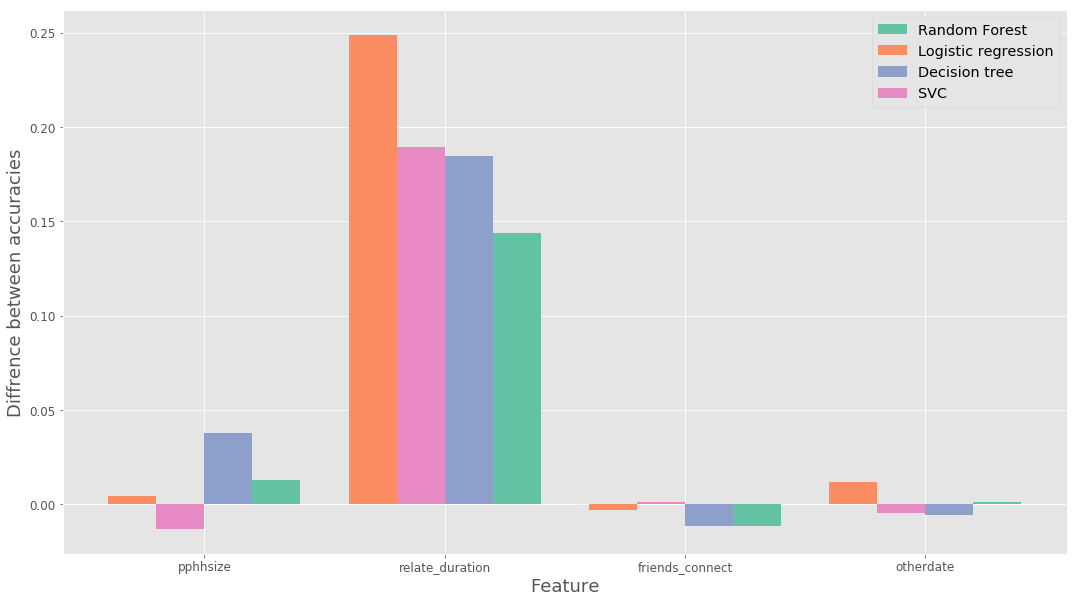

In [65]:
plt.figure(1)
for model in [(ran_clas, acc_r, -0.3, 'Random Forest'),
              (lin_clas, acc_lin, 0.3, 'Logistic regression'),
              (dec_clas, acc_dec, -0.1, 'Decision tree'),
              (svc_clas, acc_svc, 0.1, 'SVC')]:
    y_axis = [permutation_loss_drop(model=model[0], X_test=X_test, y_test=y_test, default_metric=model[1], column=column)
            for column in X_test.columns]
    x_pos = np.arange(len(X_test.columns))
    plt.bar(x_pos-model[2], y_axis,  align='center', width=0.2, label=model[3]) 
plt.ylabel('Diffrence between accuracies', fontsize=18)   
plt.xlabel('Feature', fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(x_pos, X_test.columns, fontsize=12)
plt.legend(fontsize='x-large')
plt.show()
    

#### Obserwując spadek funkcji przy perturbacjach, największe różnice jak i wartości wystepują przy zmiennej dotyczącej długości trwania związku. Zmienna mówiąca o ilości wspólnych przyjaciół nie ma poprawia klasyfikacji, ponieważ po permutacjach ogólnie dokładność jest wyższa niż wcześniej. Modele oparte na drzewach mają podobne różnice. Regresja logistyczna generuje inne zachowanie niż reszta modeli.

### ALE plot

In [63]:
def ale_func(X_data, model, chosen_feature, bins):
    data_inner = X_data.copy()
    data_inner['range_left'] = pd.cut(X_data[chosen_feature], bins).apply(lambda x: x.left).astype(float)
    data_inner['range_right'] = pd.cut(X_data[chosen_feature], bins).apply(lambda x: x.right).astype(float)
    
    lower_limit = data_inner.copy()
    lower_limit[chosen_feature] = lower_limit['range_left']
    higher_limit = data_inner.copy()
    higher_limit[chosen_feature] = higher_limit['range_right']
    
    lower_limit['target'] = model.predict_proba(lower_limit.drop(['range_left', 'range_right'], axis=1))[:,1]
    higher_limit['target'] = model.predict_proba(higher_limit.drop(['range_left', 'range_right'], axis=1))[:,1]
    
    higher_limit['diff'] = higher_limit['target'] - lower_limit['target']
    higher_limit['x_diff'] = (higher_limit['range_right'] + lower_limit['range_left'])/2
    values = higher_limit.groupby(['range_right']).mean()
    return (values['x_diff'], np.cumsum(values['diff']))

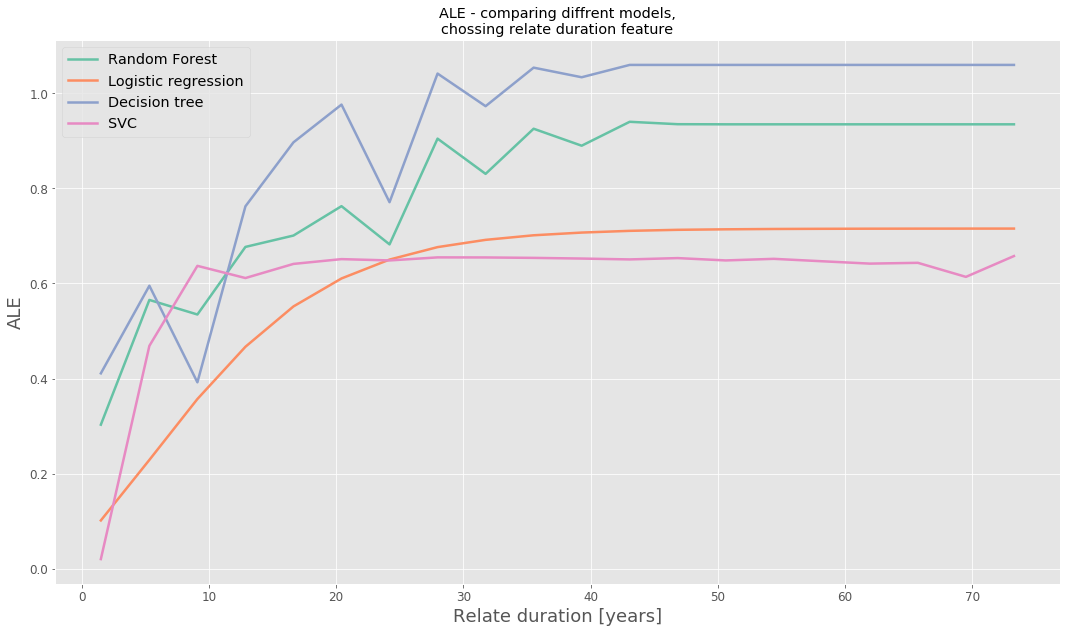

In [72]:
plt.figure(2)
for model in [(ran_clas, 'Random Forest'),
              (lin_clas, 'Logistic regression'),
              (dec_clas, 'Decision tree'),
              (svc_clas, 'SVC')]:
    plt.title('ALE - comparing diffrent models,\nchossing relate duration feature')
    x, y = ale_func(X_train, model[0], 'relate_duration', bins=20)
    plt.plot(x, y, label=model[1], linewidth=2.5)
plt.ylabel('ALE', fontsize=18)   
plt.xlabel('Relate duration [years]', fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize='x-large')
plt.show()

#### Na podstawie poprzedniego wykresu wybrano zmienną relate duration ze względu na największe różnice. Wykresy ALE plot dla modeli opartych na drzewach zachowują się analogicznie na rozkładzie zmiennej. Regresja logistyczna ze względu na cechy modelu zachowuje ciągły charakter. Wektory nośne zgodnie ze strukturą generują inny wykres niż pozostałe modele.